# 0. imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# 1. Exploring the Data

### Data set
train.csv format : \
train_landmarks/5414471.parquet **|** 5414471 **|** 1816796431 **|** 217 **|** 
3 creekhouse \
...


In [2]:
#import the data 
train_file_path = '/kaggle/input/asl-fingerspelling/train.csv'
df = pd.read_csv(train_file_path)
df

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road
...,...,...,...,...,...
67203,train_landmarks/2118949241.parquet,2118949241,388192924,88,431-366-2913
67204,train_landmarks/2118949241.parquet,2118949241,388225542,154,994-392-3850
67205,train_landmarks/2118949241.parquet,2118949241,388232076,95,https://www.tianjiagenomes.com
67206,train_landmarks/2118949241.parquet,2118949241,388235284,36,90 kerwood circle


## Open Parquet file

In [3]:
# import pandas as pd
# To make it more readable
from IPython.display import display, HTML

# Specify the file path to your Parquet file
file_path = '/kaggle/input/asl-fingerspelling/train_landmarks/5414471.parquet'

# Read the Parquet file using pandas
pf = pd.read_parquet(file_path)

# Function to create scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

html = create_scrollable_table(pf.head(5), 'points location', 'Location of points for each frame')

display(HTML(html))

## et an overview of the data

In [4]:
# get number of distinct sequence_ids in the file (i.e. amount of sequences in the file)
# distinct_sequence_count = pf.index.nunique()

# Calculate the number of lines (frames) for each sequence ID
frames = pf.index.value_counts().rename_axis('Sequence ID').reset_index(name='Frames')

# Merge the line_counts DataFrame with the new_data DataFrame based on sequence ID
table = pd.merge(frames, df[['sequence_id', 'phrase']], left_on='Sequence ID', right_on='sequence_id', how='left')

# Drop the duplicate sequence_id column
table = table.drop('sequence_id', axis=1)

# Some data seems non-sensible at first sight. For example, we have a full phone number provided in 1 phrase. Some in 6.
# We arbitrarly filter out any sequence of 30 frames or less.
frames_limit = 30 
filtered_data = table[table['Frames'] > frames_limit]

# Print the table
print(filtered_data)

     Sequence ID  Frames                          phrase
0     1829675083     672  /liyao.zhou?locale=zh_tw&_rdr/
1     1819357924     584       https://www.cultifort.com
2     1843134322     532   vintagewiring.com/koy-tanitim
3     1841427117     510            +91-87-6756-771-8086
4     1843964998     497  www.veaqee.com/evenements-2022
..           ...     ...                             ...
950   1827142511      36                    bart herrera
951   1829252886      36                 help.timepad.ru
952   1819561171      34                   23-tillbehor/
953   1835294822      32                         82 5102
954   1832369472      31                    renada keith

[955 rows x 3 columns]


### Results and explaination
Since we have a dataset that has some sequences are done in a too short amount of frames, we didn't want our model to learn some patterns that are wrong. Hence, we removed all entries that are below 30 frames

## 2. Data Preprocessing

# 3. Data visualization

In [49]:
import pandas as pd

# Create a copy of the DataFrame with desired columns
columns_to_keep = [col for col in pf.columns if 'right_hand' in col]
pf2 = pf[columns_to_keep].head(10)

# Extract the x, y, and z column names
x_columns = [col for col in pf2.columns if col.startswith('x_right_hand')]
y_columns = [col for col in pf2.columns if col.startswith('y_right_hand')]
z_columns = [col for col in pf2.columns if col.startswith('z_right_hand')]

# Combine the x, y, and z columns into a single 'hand' column
for i in range (0,21):
    pf2['right_hand_' + str(i)] = pf2.apply(lambda row: [row[x_columns][i], row[y_columns][i], row[z_columns][i]], axis=1)

# Drop the individual x, y, and z columns
pf2 = pf2.drop(x_columns + y_columns + z_columns, axis=1)

# Print the updated DataFrame

html = create_scrollable_table(pf2.head(5), 'points location', 'Location of points for each frame')

display(HTML(html))


,right_hand_0,right_hand_1,right_hand_2,right_hand_3,right_hand_4,right_hand_5,right_hand_6,right_hand_7,right_hand_8,right_hand_9,right_hand_10,right_hand_11,right_hand_12,right_hand_13,right_hand_14,right_hand_15,right_hand_16,right_hand_17,right_hand_18,right_hand_19,right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,"[0.40883234, 0.82836163, 1.4382506e-06]","[0.5199118256568909, 0.7978131771087646, -0.06529544293880463]","[0.6121594309806824, 0.729445219039917, -0.09948926419019699]","[0.7075755596160889, 0.6939002275466919, -0.13432984054088593]","[0.7973126173019409, 0.6774168610572815, -0.1693759262561798]","[0.4947091042995453, 0.6423935294151306, -0.09355349093675613]","[0.5328174233436584, 0.5563355088233948, -0.15728816390037537]","[0.5535562634468079, 0.5016429424285889, -0.1931328922510147]","[0.5662192702293396, 0.4529852867126465, -0.2178725153207779]","[0.391196072101593, 0.6480802893638611, -0.10947469621896744]","[0.3465641736984253, 0.5526783466339111, -0.19691620767116547]","[0.32939761877059937, 0.49061453342437744, -0.24585549533367157]","[0.31025558710098267, 0.43906426429748535, -0.269147664308548]","[0.3034762740135193, 0.680147647857666, -0.12974336743354797]","[0.33264490962028503, 0.645134449005127, -0.2515009343624115]","[0.40776878595352173, 0.6970512866973877, -0.27868661284446716]","[0.45275384187698364, 0.7392499446868896, -0.26652956008911133]","[0.24126681685447693, 0.72837895154953, -0.15285243093967438]","[0.3029865622520447, 0.7303779125213623, -0.2575187087059021]","[0.37297651171684265, 0.7701648473739624, -0.2758218050003052]","[0.41312986612319946, 0.7986205816268921, -0.26687607169151306]"
1816796431,"[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]"
1816796431,"[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]"
1816796431,"[0.39866304, 0.8059009, 1.6992933e-06]","[0.5236620903015137, 0.7962387800216675, -0.08268766105175018]","[0.6388072371482849, 0.7444089651107788, -0.1436004638671875]","[0.744235634803772, 0.7153571248054504, -0.19751247763633728]","[0.8325667381286621, 0.6814182996749878, -0.25110769271850586]","[0.5384860038757324, 0.6521492600440979, -0.15830622613430023]","[0.5643023252487183, 0.5919026136398315, -0.24686922132968903]","[0.5810110569000244, 0.5392497181892395, -0.2996082007884979]","[0.5976744890213013, 0.49497807025909424, -0.3369241952896118]","[0.44154077768325806, 0.6454383730888367, -0.17108780145645142]","[0.4295150637626648, 0.5787838697433472, -0.30197227001190186]","[0.4412972629070282, 0.5289520025253296, -0.37076953053474426]","[0.4532196521759033, 0.49342721700668335, -0.40809670090675354]","[0.3552692234516144, 0.6670762896537781, -0.1852167546749115]","[0.4072747230529785, 0.6777029037475586, -0.32549434900283813]","[0.4558422267436981, 0.7374459505081177, -0.34337255358695984]","[0.4889485836029053, 0.7836641669273376, -0.3282944858074188]","[0.29270997643470764, 0.706994354724884, -0.20312611758708954]","[0.3513426184654236, 0.722034215927124, -0.3157190978527069]","[0.4060916602611542, 0.7689118385314941, -0.3261038362979889]","[0.44241786003112793, 0.7999298572540283, -0.31428226828575134]"
1816796431,"[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]"

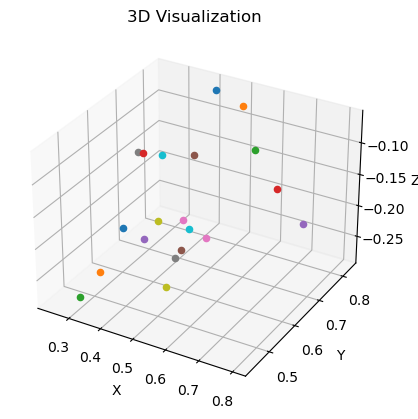

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample data
data = {
    'sequence_id': 1816796431,
    'frame': 0,
    'right_hand_0': [0.40883234, 0.82836163, -0.06529544293880463],
    'right_hand_1': [0.5199118256568909, 0.7978131771087646, -0.06529544293880463],
    'right_hand_2': [0.6121594309806824, 0.729445219039917, -0.09948926419019699],
    'right_hand_3': [0.7075755596160889, 0.6939002275466919, -0.13432984054088593],
    'right_hand_4': [0.7973126173019409, 0.6774168610572815, -0.1693759262561798],
    'right_hand_5': [0.4947091042995453, 0.6423935294151306, -0.09355349093675613],
    'right_hand_6': [0.5328174233436584, 0.5563355088233948, -0.15728816390037537],
    'right_hand_7': [0.5535562634468079, 0.5016429424285889, -0.1931328922510147],
    'right_hand_8': [0.5662192702293396, 0.4529852867126465, -0.2178725153207779],
    'right_hand_9': [0.391196072101593, 0.6480802893638611, -0.10947469621896744],
    'right_hand_10': [0.3465641736984253, 0.5526783466339111, -0.19691620767116547],
    'right_hand_11': [0.32939761877059937, 0.49061453342437744, -0.24585549533367157],
    'right_hand_12': [0.31025558710098267, 0.43906426429748535, -0.269147664308548],
    'right_hand_13': [0.3034762740135193, 0.680147647857666, -0.12974336743354797],
    'right_hand_14': [0.33264490962028503, 0.645134449005127, -0.2515009343624115],
    'right_hand_15': [0.40776878595352173, 0.6970512866973877, -0.27868661284446716],
    'right_hand_16': [0.45275384187698364, 0.7392499446868896, -0.26652956008911133],
    'right_hand_17': [0.24126681685447693, 0.72837895154953, -0.15285243093967438],
    'right_hand_18': [0.3029865622520447, 0.7303779125213623, -0.2575187087059021],
    'right_hand_19': [0.37297651171684265, 0.7701648473739624, -0.2758218050003052],
    'right_hand_20': [0.41312986612319946, 0.7986205816268921, -0.26687607169151306]
}

# Extract the coordinates for the specific frame
frame_data = {}
for i in range(0, 20):
    frame_to_add = 'right_hand_' + str(i)
    frame_data[frame_to_add] = data[frame_to_add]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
for key, coords in frame_data.items():
    ax.scatter(coords[0], coords[1], coords[2], label=key)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Visualization')

# Show the plot
plt.show()